In [124]:
 pip install -U finance_datareader

In [125]:
import FinanceDataReader as fdr
import numpy as np
import pandas as pd
import warnings
import os
import matplotlib.pylab as plt


In [126]:
#prediction 코스피 50 비교우량기업

In [127]:
df = fdr.DataReader('KS50', '2020-05-01', '2021-12-31')

In [128]:
df

,Close,Open,High,Low,Volume,Change
Date,,,,,,
2020-05-04,1731.92,1744.92,1752.99,1730.82,79750000.0,-0.0291
2020-05-06,1763.45,1753.67,1763.45,1736.17,62300000.0,0.0182
2020-05-07,1760.01,1754.82,1771.76,1751.82,50380000.0,-0.0020
2020-05-08,1776.60,1775.24,1788.83,1772.10,57710000.0,0.0094
2020-05-11,1764.12,1784.05,1792.26,1761.32,53510000.0,-0.0070
...,...,...,...,...,...,...
2021-12-13,2778.76,2795.63,2823.89,2775.82,48560000.0,-0.0024
2021-12-14,2765.08,2757.93,2775.68,2751.23,47400000.0,-0.0049
2021-12-15,2768.66,2754.17,2768.66,2746.39,34650000.0,0.0013


In [129]:
df=df.rename(columns={'Close':'Adj Close'})

In [130]:
df['CODE'] = 'SPY'
price_df = df.loc[:,['Adj Close']].copy()
price_df['center'] = price_df['Adj Close'].rolling(20).mean() # 20일 이동평균선
  # +2 표준편차를 둔 상단 밴드
price_df['ub'] = price_df['center'] + 2 * price_df['Adj Close'].rolling(20).std() 
  # -2 표준편차를 둔 하단 밴드
price_df['lb'] = price_df['center'] - 2 * price_df['Adj Close'].rolling(20).std()

n = 20 #이평선
sigma = 2 #시그마

def bollinger_band(price_df, n, sigma):
    bb = price_df.copy()
    bb['center'] = price_df['Adj Close'].rolling(n).mean() #중앙 이동평균선 
    bb['ub'] = bb['center'] + sigma * price_df['Adj Close'].rolling(n).std() # 상단 밴드
    bb['lb'] = bb['center'] - sigma * price_df['Adj Close'].rolling(n).std() # 하단 밴드
    return bb

bollinger = bollinger_band(price_df, n, sigma)

base_date = '2009-01-02'

sample = bollinger.loc[base_date:]
book = sample[['Adj Close']].copy()
book['trade'] = '' #거래내역 컬럼

def create_trade_book(sample):
  book = sample[['Adj Close']].copy()
  book['trade'] = ''
  return (book)   

book = create_trade_book(sample)

def tradings(sample, book):
    for i in sample.index:
        if sample.loc[i, 'Adj Close'] > sample.loc[i, 'ub']: # 상단밴드 이탈시 동작 안함
            book.loc[i, 'trade'] = ''
        elif sample.loc[i, 'lb'] > sample.loc[i, 'Adj Close']: # 하반밴드 이탈시 매수
            if book.shift(1).loc[i, 'trade'] == 'buy':    # 이미 매수상태라면
                book.loc[i, 'trade'] = 'buy'     # 매수상태 유지
            else:
                book.loc[i, 'trade'] = 'buy'    
        elif sample.loc[i, 'ub'] >= sample.loc[i, 'Adj Close'] and sample.loc[i, 'Adj Close'] >= sample.loc[i, 'lb']: # 볼린저 밴드 안에 있을 시
            if book.shift(1).loc[i, 'trade'] == 'buy':
               book.loc[i, 'trade'] = 'buy'  # 매수상태 유지
            else:
                book.loc[i, 'trade'] = '' # 동작 안함
    return (book) 

book = tradings(sample,book)

for i in book.index:
    if book.loc[i, 'trade'] == 'buy' and book.shift(1).loc[i, 'trade'] == '':     # long 진입
        buy = book.loc[i, 'Adj Close']
        print('진입일 : ',i, 'long 진입가격 : ', buy)
    elif book.loc[i, 'trade'] == '' and book.shift(1).loc[i, 'trade'] == 'buy':     # long 청산
        sell = book.loc[i, 'Adj Close']
        rtn = (sell - buy) / buy + 1 # 손익 계산
        book.loc[i, 'return'] = rtn
        print('청산일 : ',i, 'long 진입가격 : ', buy, ' |  long 청산가격 : ', \
              sell, ' | return:', round(rtn, 4))

    if book.loc[i, 'trade'] == '':     # zero position
        buy = 0.0
        sell = 0.0

def returns(book):
    # 손익 계산
    rtn = 1.0
    book['return'] = 1
    buy = 0.0
    sell = 0.0
    for i in book.index:
        if book.loc[i, 'trade'] == 'buy' and book.shift(1).loc[i, 'trade'] == '':     # long 진입
           buy = book.loc[i, 'Adj Close']
           print('진입일 : ',i, 'long 진입가격 : ', buy)
        elif book.loc[i, 'trade'] == '' and book.shift(1).loc[i, 'trade'] == 'buy':     # long 청산
            sell = book.loc[i, 'Adj Close']
            rtn = (sell - buy) / buy + 1 # 손익 계산
            book.loc[i, 'return'] = rtn
            print('청산일 : ',i, 'long 진입가격 : ', buy, ' |  long 청산가격 : ', \
                  sell, ' | return:', round(rtn, 4))
    
        if book.loc[i, 'trade'] == '':     # zero position
            buy = 0.0
            sell = 0.0
    
    acc_rtn = 1.0
    for i in book.index:
        rtn = book.loc[i, 'return']
        acc_rtn = acc_rtn * rtn  # 누적 수익률 계산
        book.loc[i, 'acc return'] = acc_rtn

    print ('Accunulated return :', round(acc_rtn, 4))
    return (round(acc_rtn, 4))

print(returns(book))    

진입일 :  2020-09-24 00:00:00 long 진입가격 :  2112.14
청산일 :  2020-11-09 00:00:00 long 진입가격 :  2112.14  |  long 청산가격 :  2267.12  | return: 1.0734
진입일 :  2021-04-30 00:00:00 long 진입가격 :  2940.72
청산일 :  2021-06-24 00:00:00 long 진입가격 :  2940.72  |  long 청산가격 :  3059.59  | return: 1.0404
진입일 :  2021-07-09 00:00:00 long 진입가격 :  2980.63
청산일 :  2021-11-22 00:00:00 long 진입가격 :  2980.63  |  long 청산가격 :  2798.08  | return: 0.9388
진입일 :  2021-11-30 00:00:00 long 진입가격 :  2626.14
진입일 :  2020-09-24 00:00:00 long 진입가격 :  2112.14
청산일 :  2020-11-09 00:00:00 long 진입가격 :  2112.14  |  long 청산가격 :  2267.12  | return: 1.0734
진입일 :  2021-04-30 00:00:00 long 진입가격 :  2940.72
청산일 :  2021-06-24 00:00:00 long 진입가격 :  2940.72  |  long 청산가격 :  3059.59  | return: 1.0404
진입일 :  2021-07-09 00:00:00 long 진입가격 :  2980.63
청산일 :  2021-11-22 00:00:00 long 진입가격 :  2980.63  |  long 청산가격 :  2798.08  | return: 0.9388
진입일 :  2021-11-30 00:00:00 long 진입가격 :  2626.14
Accunulated return : 1.0484
1.0484


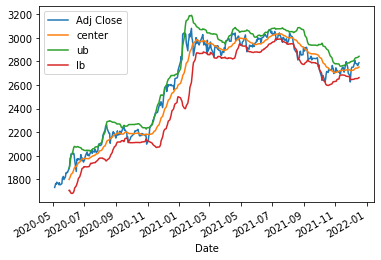

In [131]:
sample[['Adj Close',	'center',	'ub',	'lb']].plot()

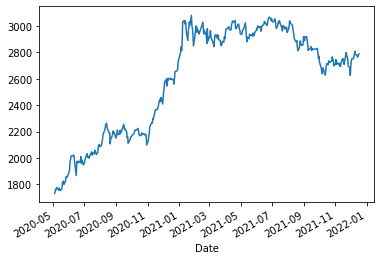

In [132]:
df['Adj Close'].plot() #수정종가

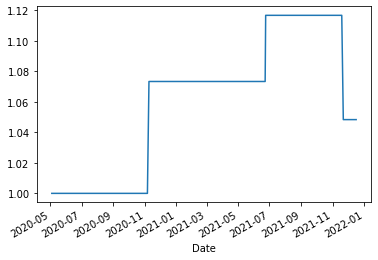

In [133]:
book['acc return'].plot() #누적수익률

In [134]:
#prediction 코스피 지수

In [135]:
df = fdr.DataReader('KS11', '2020-05-01', '2021-12-31')

In [136]:
df

,Close,Open,High,Low,Volume,Change
Date,,,,,,
2020-05-04,1895.37,1906.42,1918.66,1894.29,1.150000e+09,-0.0268
2020-05-06,1928.76,1919.45,1928.76,1902.55,1.080000e+09,0.0176
2020-05-07,1928.61,1922.00,1938.50,1918.57,7.756600e+08,-0.0001
2020-05-08,1945.82,1944.94,1956.89,1942.54,7.847700e+08,0.0089
2020-05-11,1935.40,1953.51,1960.46,1932.87,5.912800e+08,-0.0054
...,...,...,...,...,...,...
2021-12-13,3001.66,3019.67,3043.83,3000.51,3.758300e+08,-0.0028
2021-12-14,2987.95,2983.95,3001.70,2976.16,5.815700e+08,-0.0046
2021-12-15,2989.39,2979.83,2992.30,2973.00,4.328700e+08,0.0005


In [137]:
df=df.rename(columns={'Close':'Adj Close'})

In [138]:
df['CODE'] = 'SPY'
price_df = df.loc[:,['Adj Close']].copy()
price_df['center'] = price_df['Adj Close'].rolling(20).mean() # 20일 이동평균선
  # +2 표준편차를 둔 상단 밴드
price_df['ub'] = price_df['center'] + 2 * price_df['Adj Close'].rolling(20).std() 
  # -2 표준편차를 둔 하단 밴드
price_df['lb'] = price_df['center'] - 2 * price_df['Adj Close'].rolling(20).std()

n = 20 #이평선
sigma = 2 #시그마

def bollinger_band(price_df, n, sigma):
    bb = price_df.copy()
    bb['center'] = price_df['Adj Close'].rolling(n).mean() #중앙 이동평균선 
    bb['ub'] = bb['center'] + sigma * price_df['Adj Close'].rolling(n).std() # 상단 밴드
    bb['lb'] = bb['center'] - sigma * price_df['Adj Close'].rolling(n).std() # 하단 밴드
    return bb

bollinger = bollinger_band(price_df, n, sigma)

base_date = '2009-01-02'

sample = bollinger.loc[base_date:]
book = sample[['Adj Close']].copy()
book['trade'] = '' #거래내역 컬럼

def create_trade_book(sample):
  book = sample[['Adj Close']].copy()
  book['trade'] = ''
  return (book)   

book = create_trade_book(sample)

def tradings(sample, book):
    for i in sample.index:
        if sample.loc[i, 'Adj Close'] > sample.loc[i, 'ub']: # 상단밴드 이탈시 동작 안함
            book.loc[i, 'trade'] = ''
        elif sample.loc[i, 'lb'] > sample.loc[i, 'Adj Close']: # 하반밴드 이탈시 매수
            if book.shift(1).loc[i, 'trade'] == 'buy':    # 이미 매수상태라면
                book.loc[i, 'trade'] = 'buy'     # 매수상태 유지
            else:
                book.loc[i, 'trade'] = 'buy'    
        elif sample.loc[i, 'ub'] >= sample.loc[i, 'Adj Close'] and sample.loc[i, 'Adj Close'] >= sample.loc[i, 'lb']: # 볼린저 밴드 안에 있을 시
            if book.shift(1).loc[i, 'trade'] == 'buy':
               book.loc[i, 'trade'] = 'buy'  # 매수상태 유지
            else:
                book.loc[i, 'trade'] = '' # 동작 안함
    return (book) 

book = tradings(sample,book)

for i in book.index:
    if book.loc[i, 'trade'] == 'buy' and book.shift(1).loc[i, 'trade'] == '':     # long 진입
        buy = book.loc[i, 'Adj Close']
        print('진입일 : ',i, 'long 진입가격 : ', buy)
    elif book.loc[i, 'trade'] == '' and book.shift(1).loc[i, 'trade'] == 'buy':     # long 청산
        sell = book.loc[i, 'Adj Close']
        rtn = (sell - buy) / buy + 1 # 손익 계산
        book.loc[i, 'return'] = rtn
        print('청산일 : ',i, 'long 진입가격 : ', buy, ' |  long 청산가격 : ', \
              sell, ' | return:', round(rtn, 4))

    if book.loc[i, 'trade'] == '':     # zero position
        buy = 0.0
        sell = 0.0

def returns(book):
    # 손익 계산
    rtn = 1.0
    book['return'] = 1
    buy = 0.0
    sell = 0.0
    for i in book.index:
        if book.loc[i, 'trade'] == 'buy' and book.shift(1).loc[i, 'trade'] == '':     # long 진입
           buy = book.loc[i, 'Adj Close']
           print('진입일 : ',i, 'long 진입가격 : ', buy)
        elif book.loc[i, 'trade'] == '' and book.shift(1).loc[i, 'trade'] == 'buy':     # long 청산
            sell = book.loc[i, 'Adj Close']
            rtn = (sell - buy) / buy + 1 # 손익 계산
            book.loc[i, 'return'] = rtn
            print('청산일 : ',i, 'long 진입가격 : ', buy, ' |  long 청산가격 : ', \
                  sell, ' | return:', round(rtn, 4))
    
        if book.loc[i, 'trade'] == '':     # zero position
            buy = 0.0
            sell = 0.0
    
    acc_rtn = 1.0
    for i in book.index:
        rtn = book.loc[i, 'return']
        acc_rtn = acc_rtn * rtn  # 누적 수익률 계산
        book.loc[i, 'acc return'] = acc_rtn

    print ('Accunulated return :', round(acc_rtn, 4))
    return (round(acc_rtn, 4))

print(returns(book))    

진입일 :  2020-09-24 00:00:00 long 진입가격 :  2272.7
청산일 :  2020-11-09 00:00:00 long 진입가격 :  2272.7  |  long 청산가격 :  2447.2  | return: 1.0768
진입일 :  2021-02-24 00:00:00 long 진입가격 :  2994.98
청산일 :  2021-04-02 00:00:00 long 진입가격 :  2994.98  |  long 청산가격 :  3112.8  | return: 1.0393
진입일 :  2021-07-09 00:00:00 long 진입가격 :  3217.95
진입일 :  2020-09-24 00:00:00 long 진입가격 :  2272.7
청산일 :  2020-11-09 00:00:00 long 진입가격 :  2272.7  |  long 청산가격 :  2447.2  | return: 1.0768
진입일 :  2021-02-24 00:00:00 long 진입가격 :  2994.98
청산일 :  2021-04-02 00:00:00 long 진입가격 :  2994.98  |  long 청산가격 :  3112.8  | return: 1.0393
진입일 :  2021-07-09 00:00:00 long 진입가격 :  3217.95
Accunulated return : 1.1191
1.1191


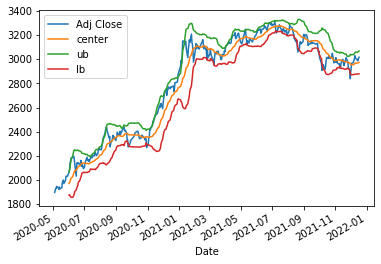

In [139]:
sample[['Adj Close',	'center',	'ub',	'lb']].plot()

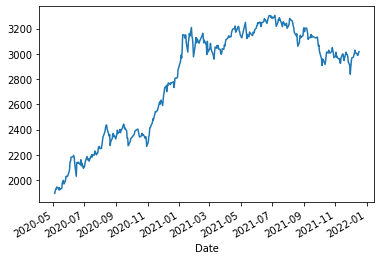

In [140]:
df['Adj Close'].plot() #수정종가

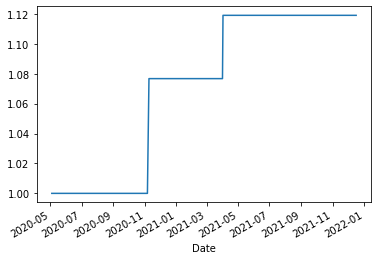

In [141]:
book['acc return'].plot() #누적수익률